# Speech Emotion Recognition Modeling

### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import IPython
import librosa # librosa is a Python library for analyzing audio and music used to extract the data from audio files it later
import librosa.display
from IPython.display import Audio # to play the audio files
plt.style.use('seaborn-white')
from python_speech_features import mfcc

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import concatenate
from keras.models import Model
from keras.layers.normalization import layer_normalization
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM
from keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.utils import np_utils, to_categorical

import torch
from pytorch_transformers import GPT2Tokenizer, GPT2LMHeadModel
import speech_recognition as sr

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

C:\Users\TestUser\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Read csv file

In [2]:
feat = pd.read_csv('feat.csv')

feat.head()

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,labels
0,-399.535004,76.428391,-23.082157,-18.684132,1.685362,15.067113,-21.209391,-5.796458,-6.386797,3.003888,...,0.434596,0.412372,0.373666,0.568295,0.573150,0.404191,0.469243,0.525294,1487.683221,Angry
1,-163.356796,16.288073,-4.017271,-9.704623,-1.823467,0.891731,-2.793187,-5.654695,-3.320916,-0.029738,...,0.683682,0.668844,0.519446,0.654436,0.713587,0.593206,0.615255,0.660334,4569.698260,Angry
2,-412.039398,77.262421,-32.583839,-24.591434,4.346249,9.090682,-26.384003,-4.067521,-6.408696,4.251380,...,0.351096,0.422755,0.433503,0.356062,0.580109,0.609401,0.420695,0.462002,1686.632515,Angry
3,-431.256287,75.581871,-25.508471,-20.642477,1.065045,14.736607,-22.362364,-6.727914,-6.420148,3.231606,...,0.413919,0.406536,0.359708,0.557236,0.573689,0.396855,0.461476,0.535765,1548.812463,Angry
4,-391.680115,94.263718,-27.733862,-28.800610,-2.881231,13.102319,-28.031700,-10.077882,-9.727766,2.450062,...,0.425077,0.347824,0.328270,0.633562,0.555491,0.397686,0.483802,0.523931,1539.644752,Angry


### Data Preparation

In [3]:
X = feat.drop(['labels'], axis = 1)

y = feat['labels']

In [4]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,-399.535004,76.428391,-23.082157,-18.684132,1.685362,15.067113,-21.209391,-5.796458,-6.386797,3.003888,...,0.362415,0.434596,0.412372,0.373666,0.568295,0.573150,0.404191,0.469243,0.525294,1487.683221
1,-163.356796,16.288073,-4.017271,-9.704623,-1.823467,0.891731,-2.793187,-5.654695,-3.320916,-0.029738,...,0.624722,0.683682,0.668844,0.519446,0.654436,0.713587,0.593206,0.615255,0.660334,4569.698260
2,-412.039398,77.262421,-32.583839,-24.591434,4.346249,9.090682,-26.384003,-4.067521,-6.408696,4.251380,...,0.424115,0.351096,0.422755,0.433503,0.356062,0.580109,0.609401,0.420695,0.462002,1686.632515
3,-431.256287,75.581871,-25.508471,-20.642477,1.065045,14.736607,-22.362364,-6.727914,-6.420148,3.231606,...,0.346212,0.413919,0.406536,0.359708,0.557236,0.573689,0.396855,0.461476,0.535765,1548.812463
4,-391.680115,94.263718,-27.733862,-28.800610,-2.881231,13.102319,-28.031700,-10.077882,-9.727766,2.450062,...,0.326723,0.425077,0.347824,0.328270,0.633562,0.555491,0.397686,0.483802,0.523931,1539.644752


In [5]:
y.value_counts()

Angry       2400
Disgust     2400
Fear        2400
Happy       2400
Neutral     2400
Surprise    2400
Sad         2400
Name: labels, dtype: int64

In [6]:
y.head()

0    Angry
1    Angry
2    Angry
3    Angry
4    Angry
Name: labels, dtype: object

This is a multiclass classification problem so I must onehot encode y

In [7]:
onehot = OneHotEncoder()

np_onehot = np.array(y).reshape(-1, 1)

y = onehot.fit_transform(np_onehot).toarray()

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Train, test, split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13440, 163), (13440, 7), (3360, 163), (3360, 7))

Scale the data using Standard Scaler

In [10]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

Insert a new axis that will appear at the axis position in the expanded array shape to make data suitable to model.

In [11]:
X_train = np.expand_dims(X_train, axis = 2)

X_test = np.expand_dims(X_test, axis = 2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13440, 163, 1), (13440, 7), (3360, 163, 1), (3360, 7))

### Modeling

#### CNN

Create an sequential CNN model

In [27]:
model_cnn = keras.Sequential(name = 'SER-CNN')

model_cnn.add(Conv1D(filters = 256, 
                 kernel_size = 5, 
                 strides = 1, 
                 padding = 'same', 
                 activation = 'relu', 
                 input_shape = (X_train.shape[1], 1)))

model_cnn.add(MaxPooling1D(pool_size = 5, 
                       strides = 2, 
                       padding = 'same'))

model_cnn.add(Conv1D(filters = 256, 
                 kernel_size = 5, 
                 strides = 1, 
                 padding = 'same', 
                 activation = 'relu')) 

model_cnn.add(MaxPooling1D(pool_size = 5, 
                       strides = 2, 
                       padding = 'same'))
          
model_cnn.add(Conv1D(filters = 256, 
                 kernel_size = 5, 
                 strides = 1, 
                 padding = 'same', 
                 activation = 'relu'))

model_cnn.add(MaxPooling1D(pool_size = 5, 
                       strides = 2, 
                       padding = 'same'))
          
model_cnn.add(Conv1D(filters = 256, 
                 kernel_size = 5, 
                 strides = 1, 
                 padding = 'same', 
                 activation = 'relu'))

model_cnn.add(MaxPooling1D(pool_size = 5, 
                       strides = 2, 
                       padding = 'same'))
          
model_cnn.add(Flatten())
          
model_cnn.add(Dense(units = 32, activation = 'relu'))
          
model_cnn.add(Dropout(0.3))
          
model_cnn.add(Dense(units = 7, activation = 'sigmoid'))
          
model_cnn.summary()

Model: "SER-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 163, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 256)           327936    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 256)          0   

In [28]:
model_cnn.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , 
              metrics = ['categorical_accuracy'])

In [29]:
history_cnn = model_cnn.fit(X_train, 
                    y_train,
                    batch_size = 128,
                    epochs = 10,
                    validation_data = (X_test, y_test))

Epoch 1/10
105/105 [==============================] - 47s 421ms/step - loss: 1.1070 - categorical_accuracy: 0.5673 - val_loss: 0.4698 - val_categorical_accuracy: 0.8676
Epoch 2/10
105/105 [==============================] - 44s 416ms/step - loss: 0.4826 - categorical_accuracy: 0.8284 - val_loss: 0.1753 - val_categorical_accuracy: 0.9435
Epoch 3/10
105/105 [==============================] - 43s 410ms/step - loss: 0.3123 - categorical_accuracy: 0.8871 - val_loss: 0.1580 - val_categorical_accuracy: 0.9518
Epoch 4/10
105/105 [==============================] - 45s 431ms/step - loss: 0.2157 - categorical_accuracy: 0.9231 - val_loss: 0.0784 - val_categorical_accuracy: 0.9756
Epoch 5/10
105/105 [==============================] - 46s 434ms/step - loss: 0.1750 - categorical_accuracy: 0.9385 - val_loss: 0.1181 - val_categorical_accuracy: 0.9604
Epoch 6/10
105/105 [==============================] - 46s 434ms/step - loss: 0.1422 - categorical_accuracy: 0.9469 - val_loss: 0.0706 - val_categorical_acc

In [30]:
score_cnn = model_cnn.evaluate(X_test, y_test)

print('Test loss:', score_cnn[0])

print('Test accuracy:', score_cnn[1])

105/105 [==============================] - 4s 38ms/step - loss: 0.0522 - categorical_accuracy: 0.9869
Test loss: 0.05215274542570114
Test accuracy: 0.9869047403335571


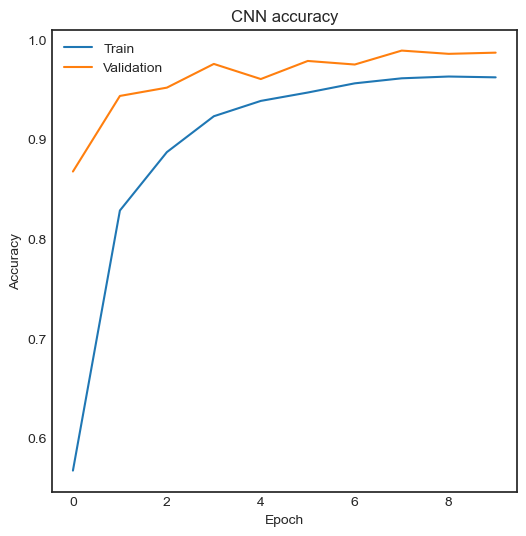

In [31]:
plt.figure(figsize = (6, 6))
plt.title('CNN accuracy')

plt.plot(history_cnn.history['categorical_accuracy'])
plt.plot(history_cnn.history['val_categorical_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

Predict on test data

In [32]:
pred_cnn = model_cnn.predict(X_test)

y_pred_cnn = onehot.inverse_transform(pred_cnn)

y_test_cnn = onehot.inverse_transform(y_test)

105/105 [==============================] - 4s 37ms/step


In [33]:
df_cnn = pd.DataFrame(columns = ['Predicted', 'Actual'])

df_cnn['Predicted'] = y_pred_cnn.flatten()

df_cnn['Actual'] = y_test_cnn.flatten()

df_cnn.head(10)

,Predicted,Actual
0,Fear,Fear
1,Fear,Fear
2,Happy,Happy
3,Sad,Sad
4,Neutral,Neutral
5,Fear,Fear
6,Surprise,Surprise
7,Sad,Sad
8,Surprise,Surprise
9,Sad,Sad


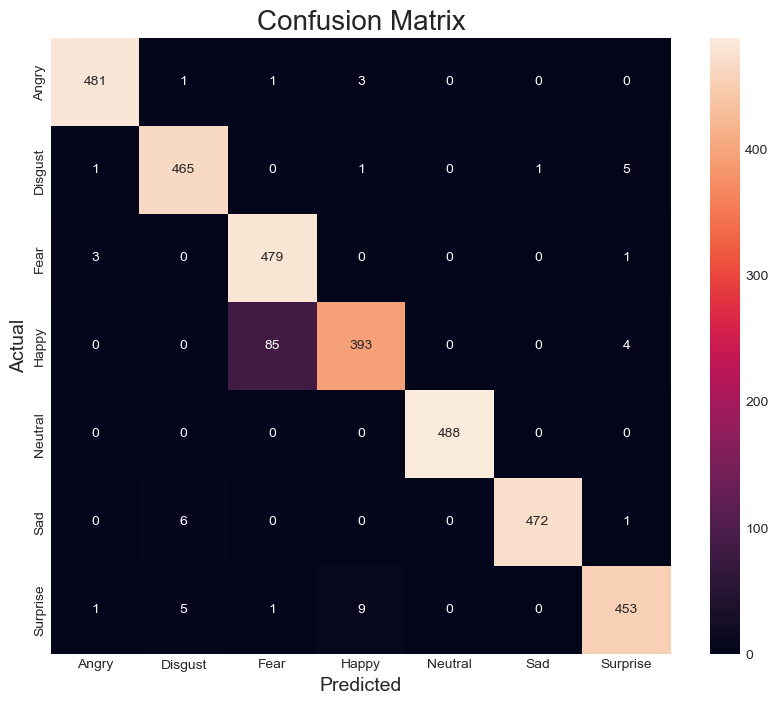

In [34]:
confusion_matrix_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)

plt.figure(figsize = (10, 8))

confusion_matrix_cnn = pd.DataFrame(confusion_matrix_cnn, 
                                    index = [x for x in onehot.categories_], 
                                    columns = [c for c in onehot.categories_])

sns.heatmap(confusion_matrix_cnn, 
            annot = True)

plt.title('CNN Confusion Matrix')

plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.show()

In [35]:
print(classification_report(y_test_cnn, y_pred_cnn))

              precision    recall  f1-score   support

       Angry       0.99      0.99      0.99       486
     Disgust       0.97      0.98      0.98       473
        Fear       0.85      0.99      0.91       483
       Happy       0.97      0.82      0.89       482
     Neutral       1.00      1.00      1.00       488
         Sad       1.00      0.99      0.99       479
    Surprise       0.98      0.97      0.97       469

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360



#### LSTM

Long Short-Term Memory Networks

In [40]:
model_lstm = keras.Sequential(name = 'SER-LSTM')

model_lstm.add(LSTM(units = 64,
                    return_sequences = True,
                    input_shape = (X_train.shape[1], 1)))

model_lstm.add(Dense(units = 64, activation = 'softmax'))

model_lstm.add(Dropout(0.2))

model_lstm.add(Flatten())

model_lstm.add(Dense(units = 7, activation = 'softmax'))

model_lstm.summary()

Model: "SER-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 163, 64)           16896     
                                                                 
 dense (Dense)               (None, 163, 64)           4160      
                                                                 
 dropout (Dropout)           (None, 163, 64)           0         
                                                                 
 flatten (Flatten)           (None, 10432)             0         
                                                                 
 dense_1 (Dense)             (None, 7)                 73031     
                                                                 
Total params: 94,087
Trainable params: 94,087
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_lstm.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , 
              metrics = ['categorical_accuracy'])

In [42]:
history_lstm = model_lstm.fit(X_train, 
                    y_train,
                    batch_size = 128,
                    epochs = 10,
                    validation_data = (X_test, y_test))

Epoch 1/10
105/105 [==============================] - 30s 257ms/step - loss: 1.5875 - categorical_accuracy: 0.3864 - val_loss: 1.0926 - val_categorical_accuracy: 0.6226
Epoch 2/10
105/105 [==============================] - 27s 259ms/step - loss: 0.8717 - categorical_accuracy: 0.6943 - val_loss: 0.7228 - val_categorical_accuracy: 0.7420
Epoch 3/10
105/105 [==============================] - 29s 277ms/step - loss: 0.6212 - categorical_accuracy: 0.7792 - val_loss: 0.5008 - val_categorical_accuracy: 0.8307
Epoch 4/10
105/105 [==============================] - 27s 258ms/step - loss: 0.4408 - categorical_accuracy: 0.8516 - val_loss: 0.3582 - val_categorical_accuracy: 0.8854
Epoch 5/10
105/105 [==============================] - 25s 241ms/step - loss: 0.3412 - categorical_accuracy: 0.8902 - val_loss: 0.2751 - val_categorical_accuracy: 0.9176
Epoch 6/10
105/105 [==============================] - 25s 241ms/step - loss: 0.2777 - categorical_accuracy: 0.9126 - val_loss: 0.2344 - val_categorical_acc

In [43]:
score_lstm = model_lstm.evaluate(X_test, y_test)

print('Test loss:', score_lstm[0])

print('Test accuracy:', score_lstm[1])

105/105 [==============================] - 3s 26ms/step - loss: 0.1476 - categorical_accuracy: 0.9577
Test loss: 0.1476108580827713
Test accuracy: 0.9577381014823914


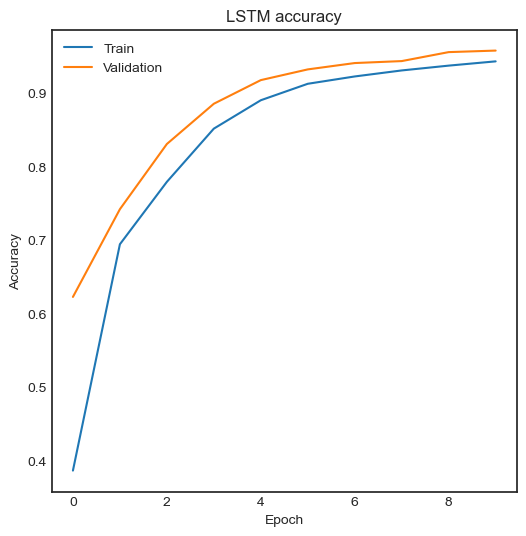

In [44]:
plt.figure(figsize = (6, 6))
plt.title('LSTM accuracy')

plt.plot(history_lstm.history['categorical_accuracy'])
plt.plot(history_lstm.history['val_categorical_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [48]:
pred_lstm = model_lstm.predict(X_test)

y_pred_lstm = onehot.inverse_transform(pred_lstm)

y_test_lstm = onehot.inverse_transform(y_test)

105/105 [==============================] - 3s 27ms/step


In [50]:
df_lstm = pd.DataFrame(columns = ['Predicted', 'Actual'])

df_lstm['Predicted'] = y_pred_lstm.flatten()

df_lstm['Actual'] = y_test_lstm.flatten()

df_lstm.head(10)

,Predicted,Actual
0,Fear,Fear
1,Fear,Fear
2,Happy,Happy
3,Sad,Sad
4,Neutral,Neutral
5,Fear,Fear
6,Surprise,Surprise
7,Sad,Sad
8,Surprise,Surprise
9,Sad,Sad


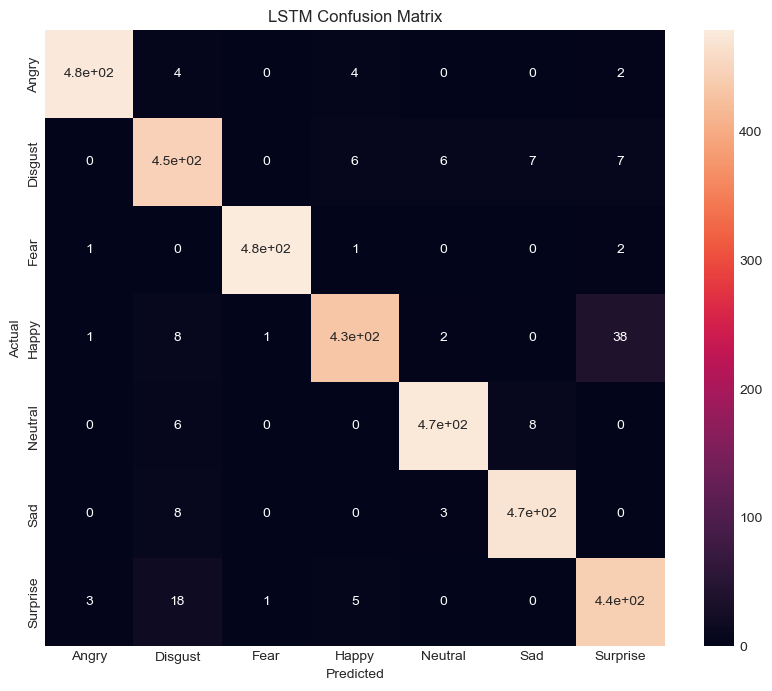

In [52]:
confusion_matrix_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize = (10, 8))

confusion_matrix_lstm = pd.DataFrame(confusion_matrix_lstm, 
                                    index = [x for x in onehot.categories_], 
                                    columns = [c for c in onehot.categories_])

sns.heatmap(confusion_matrix_lstm, 
            annot = True)

plt.title('LSTM Confusion Matrix')

plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.show()

In [53]:
print(classification_report(y_test_lstm, y_pred_lstm))

              precision    recall  f1-score   support

       Angry       0.99      0.98      0.98       486
     Disgust       0.91      0.95      0.93       473
        Fear       1.00      0.99      0.99       483
       Happy       0.96      0.90      0.93       482
     Neutral       0.98      0.97      0.97       488
         Sad       0.97      0.98      0.97       479
    Surprise       0.90      0.94      0.92       469

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360



#### Transformer

In [22]:
Tess = 'C:/Users/TestUser/OneDrive/Documents/Data Science Capstone/Dataset/TESS Toronto emotional speech set data'

In [24]:
path = []

emotion = []

directory = os.listdir(Tess)

In [25]:
for i in directory:
    
    folder = os.listdir(Tess + '/' + i)      
    
    for k in folder:
        
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('Angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('Disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('Fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('Happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('Neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('Surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('Sad')
        else:
            emotion.append('Unknown')
        path.append(Tess + "/" + i + "/" + k)

In [26]:
Tess_df = pd.DataFrame(emotion, columns = ['Emotions'])

Tess_df = pd.concat([Tess_df, pd.DataFrame(path, columns = ['Path'])], axis = 1)

In [29]:
emotion = 'Angry'

path = np.array(Tess_df['Path'][Tess_df['Emotions'] == emotion])[0]

array, sampling_rate = librosa.load(path)

IPython.display.Audio(path)

In [31]:
wave, sample_rate = torchaudio.load(path)

wave = wave.to(device)

if sample_rate != bundle.sample_rate:
    
    wave = torchaudio.functional.resample(wave, sample_rate, bundle.sample_rate)

In [32]:
with torch.inference_mode():
    
    emission, _ = model(wave)

In [34]:
class Decoder(torch.nn.Module):
    
    def __init__(self, labels, blank = 0):
        
        super().__init__()
        
        self.labels = labels
        
        self.blank = blank

        # Given a sequence emission over labels, get the best path string
    def forward(self, emission: torch.Tensor) == str:

        indices = torch.argmax(emission, dim = -1) 
        
        indices = torch.unique_consecutive(indices, dim = -1)
        
        indices = [i for i in indices if i != self.blank]
        
        # The resulting transcript
        return "".join([self.labels[i] for i in indices])   

In [35]:
decoder = Decoder(labels = bundle.get_labels())

transcript = decoder(emission[0])

In [36]:
print(transcript)

IPython.display.Audio(path)

SAY|THE|WORD|BACK|


#### VGG16

In [42]:
model_vgg16 = keras.Sequential(name = 'SER-VGG16')

model_vgg16.add(VGG19(
    include_top = False,
    weights = None,
    input_tensor = None,
    input_shape = (128, 163, 1),
    pooling = None,
    classes = 7,
    classifier_activation = 'softmax'
))

model_vgg16.add(Flatten())

model_vgg16.add(Dense(units = 7, activation = 'softmax'))

model_vgg16.summary()

Model: "SER-VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 5, 512)         20023232  
                                                                 
 flatten_3 (Flatten)         (None, 10240)             0         
                                                                 
 dense_6 (Dense)             (None, 7)                 71687     
                                                                 
Total params: 20,094,919
Trainable params: 20,094,919
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_vgg16.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , 
              metrics = ['categorical_accuracy'])

In [44]:
history_vgg16 = model_vgg16.fit(X_train, 
                    y_train,
                    batch_size = 128,
                    epochs = 10,
                    validation_data = (X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\TestUser\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\TestUser\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\TestUser\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\TestUser\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\TestUser\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\TestUser\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "SER-VGG16" is incompatible with the layer: expected shape=(None, 128, 163, 1), found shape=(128, 163, 1)


#### GoogLeNet

Create an Inception block.

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
    path1 = Conv2D(filters = f1, kernel_size = (1, 1), padding = 'same', activation = 'relu')(input_layer)
    
  # 2nd path:
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1, 1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3, 3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1, 1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (4, 4), padding = 'same', activation = 'relu')(path3)

  # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

In [ ]:
model_googlenet = keras.Sequential(name = 'SER-GoogLeNet')

model_googlenet.add(Conv2D(filters = 64, 
                 kernel_size = (7, 7), 
                 strides = 2, 
                 padding = 'valid', 
                 activation = 'relu', 
                 input_shape = (X_train.shape)))

model_googlenet.add(MaxPooling2D(pool_size = (3, 3), strides = 2))

model_googlenet.add(Conv2D(filters = 64, kernel_size = (1, 1), strides = 1, padding = 'same', activation = 'relu')) 

model_googlenet.add(Conv2D(filters = 192, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
          
model_googlenet.add(MaxPooling2D(pool_size = (3, 3), strides = 2))

model_googlenet.add(Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32))
          
model_googlenet.add(Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64))

model_googlenet.add(MaxPooling2D(pool_size = (3, 3), strides = 2))
          
model_googlenet.add(Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64))
          
model_googlenet.add(AveragePooling2D(pool_size = (5, 5), strides = 3))
          
model_googlenet.add(Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu'))

model_googlenet.add(Flatten())

model_googlenet.add(Dense(1024, activation = 'relu'))

model_googlenet.add(Dropout(0.7))

model_googlenet.add(Dense(5, activation = 'softmax'))

model_googlenet.add(Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64))

model_googlenet.add(Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64))

model_googlenet.add(Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64))

model_googlenet.add(AveragePooling2D(pool_size = (5,5), strides = 3))

model_googlenet.add(Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu'))

model_googlenet.add(Flatten())

model_googlenet.add(Dense(1024, activation = 'relu'))

model_googlenet.add(Dropout(0.7))

model_googlenet.add(Dense(1000, activation = 'softmax'))

model_googlenet.add(Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128))

model_googlenet.add(MaxPooling2D(pool_size = (3,3), strides = 2))

model_googlenet.add(Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128))

model_googlenet.add(Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128))

model_googlenet.add(GlobalAveragePooling2D(name = 'GAPL'))

model_googlenet.add(Dropout(0.4))
          
model_googlenet.add(Dense(units = 7, activation = 'sigmoid'))
          
model_googlenet.summary()

In [ ]:
model_googlenet = GoogLeNet()

In [ ]:
model_googlenet.summary()

In [ ]:
model_googlenet.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , 
              metrics = ['categorical_accuracy'])

In [ ]:
history_lstm = model_googlenet.fit(X_train, 
                    y_train,
                    batch_size = 128,
                    epochs = 10,
                    validation_data = (X_test, y_test))

In [ ]:
score_googlenet = model_googlenet.evaluate(X_test, y_test)

print('Test loss:', score_googlenet[0])

print('Test accuracy:', score_googlenet[1])

#### AlexNet

In [ ]:
model_alexnet = keras.Sequential(name = 'SER-AlexNet')

# 1st Layer
model_alexnet.add(Conv2D(filters = 96, 
                   input_shape = (X_train.shape[1], 1), 
                   kernel_size = (11, 11), 
                   strides = (3, 3), 
                   padding = 'same'))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

model_alexnet.add(MaxPooling2D(pool_size = (2, 2), 
                               strides = (2, 2), 
                               padding = 'same'))

# 2nd Layer

model_alexnet.add(Conv2D(filters = 256, 
                         kernel_size = (5, 5), 
                         strides =(1, 1), 
                         padding = 'same'))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

model_alexnet.add(MaxPooling2D(pool_size = (2, 2), 
                               strides = (2, 2), 
                               padding = 'same'))

# 3rd Layer

model_alexnet.add(Conv2D(filters = 384, 
                         kernel_size = (3, 3), 
                         strides = (1, 1), 
                         padding = 'same'))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

# 4th Layer

model_alexnet.add(Conv2D(filters = 384, 
                         kernel_size = (3, 3), 
                         strides = (1, 1), 
                         padding = 'same'))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

# 5th Layer

model_alexnet.add(Conv2D(filters = 256, 
                         kernel_size = (3, 3), 
                         strides = (1, 1), 
                         padding = 'same'))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

model_alexnet.add(MaxPooling2D(pool_size = (2, 2), 
                               strides = (2, 2), 
                               padding = 'same'))

model_alexnet.add(Flatten())

# 1st Connected Layer

model_alexnet.add(Dense(4096, 
                        input_shape = (X_train.shape[1], 1)))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

model_alexnet.add(Dropout(0.4))

# 2nd Connected Layer

model_alexnet.add(Dense(4096))

model_alexnet.add(BatchNormalization()) 

model_alexnet.add(Activation('relu'))

model_alexnet.add(Dropout(0.4))

# 3rd Connected Layer

model_alexnet.add(Dense(1000))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('relu'))

model_alexnet.add(Dropout(0.4))

# Output Layer

model_alexnet.add(Dense(7))

model_alexnet.add(BatchNormalization())

model_alexnet.add(Activation('softmax'))

# Summary

model_alexnet.summary()